# Molecular similarity-based clustering of NorA inhibitors from the chEMBL database

This notebook contains a workflow for accessing NorA ligands from the chEMBL database, and DBSCAN clustering of the obtained inhibitors.

The workflow is on the teachopenCADD talktorial, which can be found here:
https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html

In [23]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 100)
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
import numpy as np
from IPython.display import Image, HTML
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [166]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity
assays_api = new_client.assay
documents_api = new_client.document

In [167]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

## Fetch target data from ChEMBL

Next, we get the target from the ChEMBL database (we select that from a search on ChEMBL database, directly)

Quinolone resistance protein norA, ChEMBL ID: CHEMBL5114

In [168]:
chembl_id_target = "CHEMBL5114"
target = targets_api.get(chembl_id_target)

## Get bioactivity data

Let's download bioactivity data from ChEMBL. This can take a few minutes.

In [169]:
activities = bioactivities_api.filter(
    target_chembl_id=chembl_id_target,
    assay_type="B")
df_activities = pd.DataFrame.from_records(activities)
df_activities.to_csv("../data/df_activities.csv", index=False)

From this data frame, we only use standardized measurement values by ChEMBL (because measurements may have been conducted and reported in different units). This is not absolutely necessary for our purposes here (since, again, we're not interested in affinities), we do this anyway.

In [170]:
#df_activities.drop(["units","value"],axis=1, inplace=True)
df_activities.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,Active,2178413,[],CHEMBL966377,Inhibition of Staphylococcus aureus NorA MDR e...,B,None,None,BAO_0000375,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,Activity,None,None,None,None
1,None,Active,2178413,[],CHEMBL966377,Inhibition of Staphylococcus aureus NorA MDR e...,B,None,None,BAO_0000375,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,Activity,None,None,None,None
2,None,Active,2178414,[],CHEMBL966377,Inhibition of Staphylococcus aureus NorA MDR e...,B,None,None,BAO_0000375,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,Activity,None,None,None,None
3,None,Active,2178415,[],CHEMBL966377,Inhibition of Staphylococcus aureus NorA MDR e...,B,None,None,BAO_0000375,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,Activity,None,None,None,None
4,None,Active,2178416,[],CHEMBL966377,Inhibition of Staphylococcus aureus NorA MDR e...,B,None,None,BAO_0000375,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,Activity,None,None,None,None


## Preprocess and filter bioactivity data

Data frame shape: (730, 46)


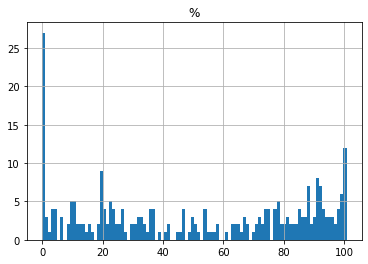

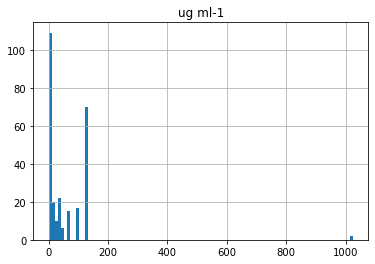

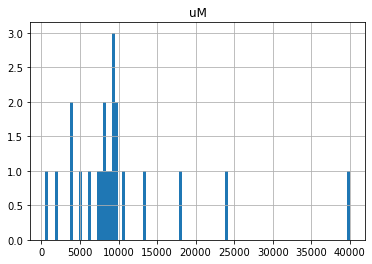

['Inhibition' 'MIC' 'Activity' 'MEC' 'IC50' 'MMC']


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
6,None,None,2458965,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,69.7
9,None,None,2458968,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,84.7
17,None,None,2458976,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,81.6
18,None,None,2458977,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,81.0
128,None,None,2615671,[],CHEMBL1017717,Inhibition of NorA efflux pump in Staphylococc...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,73.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,None,None,18408269,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,93.8
633,None,None,18408270,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,80.3
634,None,None,18408271,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,86.7
635,None,None,18408272,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,91.4


In [171]:
### 1. Convert datatype of "standard_value" from "object" to "float"
# This field holds standardized values. In order to make these values usable in calculations later on, convert values to floats.
df_activities = df_activities.astype({"standard_value":"float64"})

### 2. Delete duplicate molecules
# Sometimes the same molecule has been tested more than once, in this case, we only keep the first one.

# **You may decide to keep the one with best value or mean value of all assays**
df_activities.drop_duplicates("molecule_chembl_id", keep="first",
                             inplace=True)

### 3. Reset "DataFrame" index
# We deleted some rows, but we want to iterate over the index later. So we reset the index to be continuous!
df_activities.reset_index(drop=True,inplace=True)

# How many unique molecules do we have now?
print(f"Data frame shape: {df_activities.shape}")

### 4. Filter out molecules that are not inhibitors
# Drop None from values
df_activities = df_activities[df_activities.standard_value.notnull()]

# Drop None from units
df_activities = df_activities[df_activities.standard_units.notnull()]

# Drop "s" from units
df_activities = df_activities[~df_activities.units.str.contains("s", na=False)]

# Drop rows that include comment "not active" from activity_comment column, if the value is not None
df_activities = df_activities[~df_activities.activity_comment.str.contains("Not Active", na=False)]

# Get a list of units
units = df_activities.units.unique()

# For each unit, plot a histogram of the standard values
for unit in units:
    df_activities[df_activities.units == unit].standard_value.hist(bins=100)
    plt.title(unit)
    plt.show()

# Get a list of standard_types
standard_types = df_activities.standard_type.unique()
print(standard_types)
    
# Seems like we should only select % as units.
# Let's filter the data frame to only include % as units
df_activities = df_activities[df_activities.units == "%"]

# Only keep rows with a standard_value higher than 60
df_inhibitors = df_activities[df_activities.standard_value > 60]
df_inhibitors.to_csv("../data/df_inhibitors.csv", index=False)
df_inhibitors

### Get assay and publication information

In [211]:
assays = [assays_api.get(aid) for aid in np.unique(df_inhibitors["assay_chembl_id"])]
dids = np.unique([assay["document_chembl_id"] for assay in assays])
docs = [documents_api.get(did) for did in dids]
print(len(assays))
df_docs = pd.DataFrame.from_records(docs)
df_docs.filter(["year","authors","title","doi"]).sort_values(by="year",ascending=False)
df_docs.to_csv("../data/df_docs.csv", index=False)

12


## Getting compound data

Now we have a DataFrame containing all molecules tested against NorA.

Next, we want to get molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs.

In [173]:
compounds = compounds_api.filter(molecule_chembl_id__in=list(
    df_inhibitors["molecule_chembl_id"]))
df_compounds = pd.DataFrame.from_records(compounds)
print(f"DataFrame shape: {df_compounds.shape}")

DataFrame shape: (126, 35)


### Remove entries with missing molecule structure entry

In [175]:
df_compounds.dropna(axis=0, how="any", subset=["molecule_structures"], inplace=True)
print(f"DataFrame shape: {df_compounds.shape}")

DataFrame shape: (126, 35)


### Delete duplicate molecules

In [176]:
df_compounds.drop_duplicates("molecule_chembl_id",keep="first",
                            inplace=True)
print(f"DataFrame shape: {df_compounds.shape}")

DataFrame shape: (125, 35)


In [177]:
df_inhibitors

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
6,None,None,2458965,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,69.7
9,None,None,2458968,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,84.7
17,None,None,2458976,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,81.6
18,None,None,2458977,[],CHEMBL1015715,Inhibition of NorA pump-mediated ethidium brom...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,81.0
128,None,None,2615671,[],CHEMBL1017717,Inhibition of NorA efflux pump in Staphylococc...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,73.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,None,None,18408269,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,93.8
633,None,None,18408270,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,80.3
634,None,None,18408271,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,86.7
635,None,None,18408272,[],CHEMBL4151511,Inhibition of NorA in Staphylococcus aureus SA...,B,None,None,BAO_0000201,...,Staphylococcus aureus,Quinolone resistance protein norA,1280,None,None,INH,%,UO_0000187,None,91.4


### Get molecules with canonical SMILES

In [178]:
df_compounds.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [179]:
canonical_smiles = []

for i, compounds in df_compounds.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

df_compounds["smiles"] = canonical_smiles
df_compounds.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {df_compounds.shape}")

DataFrame shape: (125, 35)


In [180]:
df_compounds

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chemical_probe,chirality,cross_references,dosed_ingredient,first_approval,...,prodrug,structure_type,therapeutic_flag,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_flag,smiles
0,[N05AC02],-2,None,1,9566.0,0,0,"[{'xref_id': 'thioridazine%20hydrochloride', '...",True,1962.0,...,0,MOL,True,False,None,None,None,1962.0,True,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2
2,[N05AA01],1,None,1,3647.0,0,2,"[{'xref_id': 'chlorpromazine%20hydrochloride',...",True,1957.0,...,0,MOL,True,True,None,None,None,NaN,False,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21
3,[N06AB05],1,None,1,7936.0,0,1,"[{'xref_id': 'paroxetine%20hydrochloride', 'xr...",False,1992.0,...,0,MOL,True,False,-oxetine,antidepressants (fluoxetine type),-oxetine,1989.0,False,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1
4,[N05AE03],-2,None,0,9122.0,0,2,"[{'xref_id': '144206958', 'xref_name': 'SID: 1...",True,NaN,...,0,MOL,True,False,None,None,None,1992.0,True,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...
5,"[M01AH01, L01XX33]",1,None,1,41423.0,0,2,"[{'xref_id': 'celecoxib', 'xref_name': 'celeco...",True,1998.0,...,0,MOL,True,False,-coxib,cyclooxygenase-2 inhibitors,-coxib,1998.0,False,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,[],-1,None,0,NaN,0,-1,[],False,NaN,...,-1,MOL,False,False,None,None,None,NaN,False,CCCOc1ccc(-c2cc(OCCN3CCc4cc(OC)c(OC)cc4C3)c3c(...
122,[],-1,None,0,NaN,0,-1,[],False,NaN,...,-1,MOL,False,False,None,None,None,NaN,False,CCCOc1ccc(-c2cc(OCCN(CC)CC)c3cc(OC)c(OC)cc3n2)cc1
123,[],-1,None,0,NaN,0,-1,[],False,NaN,...,-1,MOL,False,False,None,None,None,NaN,False,CCCOc1ccc(-c2cc(OCCCN(C)C)c3ccc(OC)cc3n2)cc1
124,[],-1,None,0,NaN,0,-1,[],False,NaN,...,-1,MOL,False,False,None,None,None,NaN,False,CCCOc1ccc(-c2cc(OCCCN(C)C)c3cccc(OC)c3n2)cc1


### Adding molecule structures

In [181]:
PandasTools.AddMoleculeColumnToFrame(df_compounds,smilesCol="smiles")

In [182]:
df_compounds.reset_index(drop=True,inplace=True)

In [183]:
#HTML(df_compounds.to_html(escape=False))

### Writing SDF file with RDKit

Now that we have finalized our DataFrame, what we may want is an SDF file that contains all of these molecules, so that we can use them in docking simulations later on!

In [184]:
PandasTools.WriteSDF(df_compounds,"../data/df_compounds.sdf",idName="molecule_chembl_id")

### Writing the DataFrame as well!

In [185]:
df_compounds.to_csv("../data/df_compounds.csv")

## Molecular similarity

### Read from the saved dataframe, and compute molecular similarity

In [6]:
df_compounds = pd.read_csv("../data/df_compounds.csv")

In [7]:
from itertools import repeat
smiles = df_compounds.smiles
tanimoto_mat = np.zeros((len(smiles),len(smiles)))
molecules = map(Chem.MolFromSmiles,smiles)
fingerprints = list(map(Chem.RDKFingerprint,molecules))
cross_fingerprints = [np.array(list(map(DataStructs.TanimotoSimilarity,fingerprints,repeat(fp)))) for fp in fingerprints]

In [8]:
cross_fingerprints = np.vstack(cross_fingerprints)

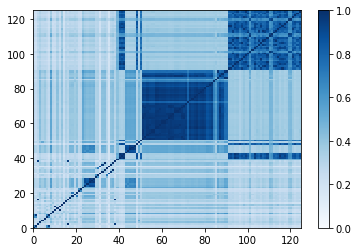

In [9]:
plt.pcolor(cross_fingerprints,cmap="Blues",vmin=0,vmax=1)
plt.colorbar()
plt.show()

## Clustering

In [10]:
distance_matrix = np.sqrt(2*(1-cross_fingerprints))

In [11]:
# Define the maximum distance between two points
eps = 0.8

# Definethe minimum number of points required to form a dense region
min_samples = 5

# Initialize the DBSCAN model
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")

# Fit the model to the similarity matrix
dbscan.fit(cross_fingerprints)

# Get the cluster labels
cluster_labels = dbscan.labels_

# Print the cluster labels
print(cluster_labels)

[-1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  2  2  0  0  0  0  0
  2 -1  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3 -1 -1  3  3  3  3  3  2  2  2  2  2
  2  2  2  2  2  4  2  2  2  2  2  2  2  2  4  4  2  2  2  2  2  2  2  4
  4  2  2  2  2]


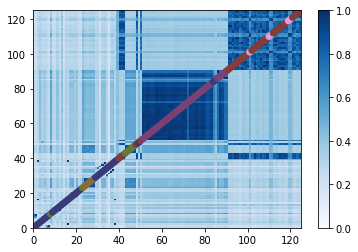

In [16]:
# Overlay clusters on fingerprints
plt.pcolor(cross_fingerprints,cmap="Blues",vmin=0,vmax=1)
plt.colorbar() 
plt.scatter(range(len(cluster_labels)),range(len(cluster_labels)),c=cluster_labels,cmap="tab20b")
plt.show()

In [12]:
# For each value found in cluster_labels, count how many times it appears in the array
unique, counts = np.unique(cluster_labels, return_counts=True)

In [13]:
print(unique, counts)

[-1  0  1  2  3  4] [36  7  5 34 38  5]


In [14]:
# Assign the cluster labels to the data frame
df_compounds["cluster"] = cluster_labels

In [195]:
PandasTools.AddMoleculeColumnToFrame(df_compounds,smilesCol="smiles")
df_compounds.reset_index(drop=True,inplace=True)

In [196]:
# Save an SDF file with the cluster information in the molecule name for each cluster found in the data frame
for cluster in unique:
    PandasTools.WriteSDF(df_compounds[df_compounds.cluster == cluster],
                         f"../data/cluster_{cluster}.sdf",
                         molColName="ROMol",
                         properties=list(df_compounds.columns),
                         allNumeric=False,
                         idName='molecule_chembl_id')

In [197]:
# Save df_compounds with cluster information
df_compounds.to_csv("../data/df_compounds.csv", index=False)

## Supplement df_inhibitors with cluster and publication information

In [198]:
# Save df_compounds with assay and document information
assays = [assays_api.get(aid) for aid in df_inhibitors["assay_chembl_id"]]
dids = [assay["document_chembl_id"] for assay in assays]
docs = [documents_api.get(did) for did in dids]
print(len(assays))
df_docs = pd.DataFrame.from_records(docs)

125


In [199]:
# Merge df_compounds and df_inhibitors based on molecule_chembl_id
df_inhibitors = pd.merge(df_inhibitors, df_compounds, on="molecule_chembl_id", how='right')

# Merge df_inhibitors and df_docs based on document_chembl_id
df_inhibitors = pd.merge(df_inhibitors, df_docs, on="document_chembl_id", how='outer')

# Drop duplicates
df_inhibitors.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)

In [200]:
# Save df_inhibitors
df_inhibitors.to_csv("../data/df_inhibitors.csv", index=False)

## Which cluster was published in which study?

In [3]:
df_inhibitors = pd.read_csv("../data/df_inhibitors.csv")

In [4]:
# Find out which cluster was published in which study
for cluster in np.unique(df_inhibitors["cluster"]):
    df_cluster = df_inhibitors[df_inhibitors["cluster"] == cluster]
    print(f"Cluster {cluster}, including {len(df_cluster)} compounds, was published in:")
    print(df_cluster["doi"].unique())


Cluster -1, including 36 compounds, was published in:
['10.1021/jm1011963' '10.1021/jm701623q' '10.1021/ml200293c'
 '10.1021/jm201446h' '10.1021/acs.jmedchem.6b01439' '10.1021/jm400262a'
 '10.1021/acs.jmedchem.5b01219']
Cluster 0, including 7 compounds, was published in:
['10.1021/jm1011963' '10.1021/jm701623q' '10.1016/j.ejmech.2008.01.042']
Cluster 1, including 5 compounds, was published in:
['10.1021/jm1003304']
Cluster 2, including 34 compounds, was published in:
['10.1021/jm1011963' '10.1021/jm400262a' '10.1021/jm200370y'
 '10.1021/acs.jmedchem.8b00791']
Cluster 3, including 38 compounds, was published in:
['10.1021/acs.jmedchem.5b01219' '10.1021/acs.jmedchem.6b01281']
Cluster 4, including 5 compounds, was published in:
['10.1021/acs.jmedchem.8b00791']


In [5]:
# Find out how many compounds were published in each study
for doi in df_inhibitors["doi"].unique():
    df_doi = df_inhibitors[df_inhibitors["doi"] == doi]
    print(f"{len(df_doi)} compounds were published in {doi}")

26 compounds were published in 10.1021/jm1011963
4 compounds were published in 10.1021/jm701623q
7 compounds were published in 10.1021/ml200293c
2 compounds were published in 10.1021/jm201446h
3 compounds were published in 10.1021/acs.jmedchem.6b01439
2 compounds were published in 10.1021/jm400262a
1 compounds were published in 10.1016/j.ejmech.2008.01.042
5 compounds were published in 10.1021/jm1003304
1 compounds were published in 10.1021/jm200370y
35 compounds were published in 10.1021/acs.jmedchem.5b01219
5 compounds were published in 10.1021/acs.jmedchem.6b01281
34 compounds were published in 10.1021/acs.jmedchem.8b00791


In [36]:
# For each cluster, determine the maximum common substructure, and draw it
for cluster in np.unique(df_inhibitors["cluster"]):
    df_cluster = df_inhibitors[df_inhibitors["cluster"] == cluster]
    mols = [Chem.MolFromSmiles(smiles) for smiles in df_cluster["smiles"]]
    mcs = rdFMCS.FindMCS(mols)
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    mcs_mol.SetProp("_Name", f"Cluster {cluster}")
    Draw.MolToImageFile(mcs_mol, f"cluster_{cluster}_mcs.png")
    # Convert mcs_mol to SMILES
    mcs_smiles = Chem.MolToSmiles(mcs_mol)
    print(f"Cluster {cluster} MCS SMILES: {mcs_smiles}")

Cluster -1 MCS SMILES: C1:C:C:C:C:C:1
Cluster 0 MCS SMILES: CCCCCNC:C:C:C(:C:CCO):C(:C):NCC
Cluster 1 MCS SMILES: CCOC(=O)C1=CN(C2CC2)C2:C:C(N3CCC4=C(CCCS4)C3):C:C:C:2C1
Cluster 2 MCS SMILES: CCOC1:C:C:C(C2:C:C(O):C3:C:C:C:C:C:3:N:2):C:C:1
Cluster 3 MCS SMILES: C:C:C:C:C:CCN1:C(C):C(C(=O)OCC):C2:C:C(OCC):C:C:C:2:1
Cluster 4 MCS SMILES: CCCOC1:C:C:C(C2:C:C(OCCN3CCC4:C:C(OC):C(OC):C:C:4C3):C3:C:C:C:C:C:3:N:2):C:C:1
